In [1]:
import anndata as ad
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import combinations

from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
import statsmodels.api as sm
from statsmodels.formula.api import ols

import seaborn as sns
from scipy.stats import f_oneway

In [2]:
fdata = sc.read_h5ad("./RNA/Multitime.clustered.h5")

In [3]:
data_list = ["./RNA/B924-1.guide.bin_100.h5", "./RNA/B926-1.guide.bin_100.h5", "./RNA/B922-1.guide.bin_100.h5",
             "./RNA/B924-2.guide.bin_100.h5", "./RNA/B926-2.guide.bin_100.h5", "./RNA/B922-2.guide.bin_100.h5"]
marker = ["1-1", "2-1", "3-1", "1-2", "2-2", "3-2"]

In [4]:
anndata_list = []
for idx, data in enumerate(data_list):
    anndata_ = sc.read_h5ad(data)
    anndata_.obs["marker"] = marker[idx]
    anndata_list.append(anndata_)
guide_data = ad.concat(anndata_list, join="outer")
guide_data.obs_names_make_unique()

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
def clean_guide_data(rnadata, guidedata):

    rnadata.obs["cov"] = [str(marker) + '_' + str(array[0]) + "-" + str(array[1]) for marker, array in zip(rnadata.obs["marker"], rnadata.obsm["spatial"])]
    guidedata.obs["cov"] = [str(marker) + '_' + str(array[0]) + "-" + str(array[1]) for marker, array in zip(guidedata.obs["marker"], guidedata.obsm["spatial"])]

    common_cov = np.intersect1d(rnadata.obs['cov'], guidedata.obs['cov'])
    guidedata.obs_names = guidedata.obs['cov']
    rnadata.obs_names = rnadata.obs['cov']

    guidedata_filtered = guidedata[common_cov].copy()
    sorted_obs_names = rnadata.obs_names.sort_values()
    guidedata_filtered = guidedata_filtered[sorted_obs_names].copy()
    rnadata = rnadata[sorted_obs_names].copy()
    missing_cov = rnadata.obs['cov'][~rnadata.obs['cov'].isin(common_cov)]
    if len(missing_cov) > 0:
        missing_obs = pd.DataFrame({'marker': [cov.split('_')[0] for cov in missing_cov]}, index=missing_cov)
        missing_obsm_spatial = np.array([[float(cov.split('_')[1].split('-')[0]), float(cov.split('_')[1].split('-')[1])] for cov in missing_cov])
        missing_X = np.zeros((len(missing_cov), guidedata.shape[1]))  # 假设 guidedata 和 rnadata 的 shape[1] 相同

        missing_guidedata = ad.AnnData(X=missing_X, obs=missing_obs, obsm={'spatial': missing_obsm_spatial})
        guidedata_filtered = guidedata_filtered.concatenate(missing_guidedata)
    return rnadata, guidedata_filtered

In [7]:
fdata, guide_data = clean_guide_data(fdata, guide_data)

In [8]:
guide_data[:, 'sgNTC'].X = guide_data[:, ['sgNTC', 'sgnon-targeting_2_gene', 'sgnon-targeting_1_gene']].X.sum(axis=1)

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [9]:
guide_data = guide_data[:, :-2].copy()

In [10]:
guide_data.write_h5ad("./RNA/Multitime.guide.h5")

In [11]:
guide_data.obs["cluster"] = fdata.obs["cluster_cellcharter_givenk"].tolist()

In [12]:
fdata.obs_names

Index(['1-1_10049-10049', '1-1_10049-10149', '1-1_10049-10249',
       '1-1_10049-10349', '1-1_10049-10449', '1-1_10049-10549',
       '1-1_10049-10649', '1-1_10049-10749', '1-1_10049-10849',
       '1-1_10049-10949',
       ...
       '3-2_9949-9149', '3-2_9949-9249', '3-2_9949-9349', '3-2_9949-9449',
       '3-2_9949-949', '3-2_9949-9549', '3-2_9949-9649', '3-2_9949-9749',
       '3-2_9949-9849', '3-2_9949-9948'],
      dtype='object', name='cov', length=118279)

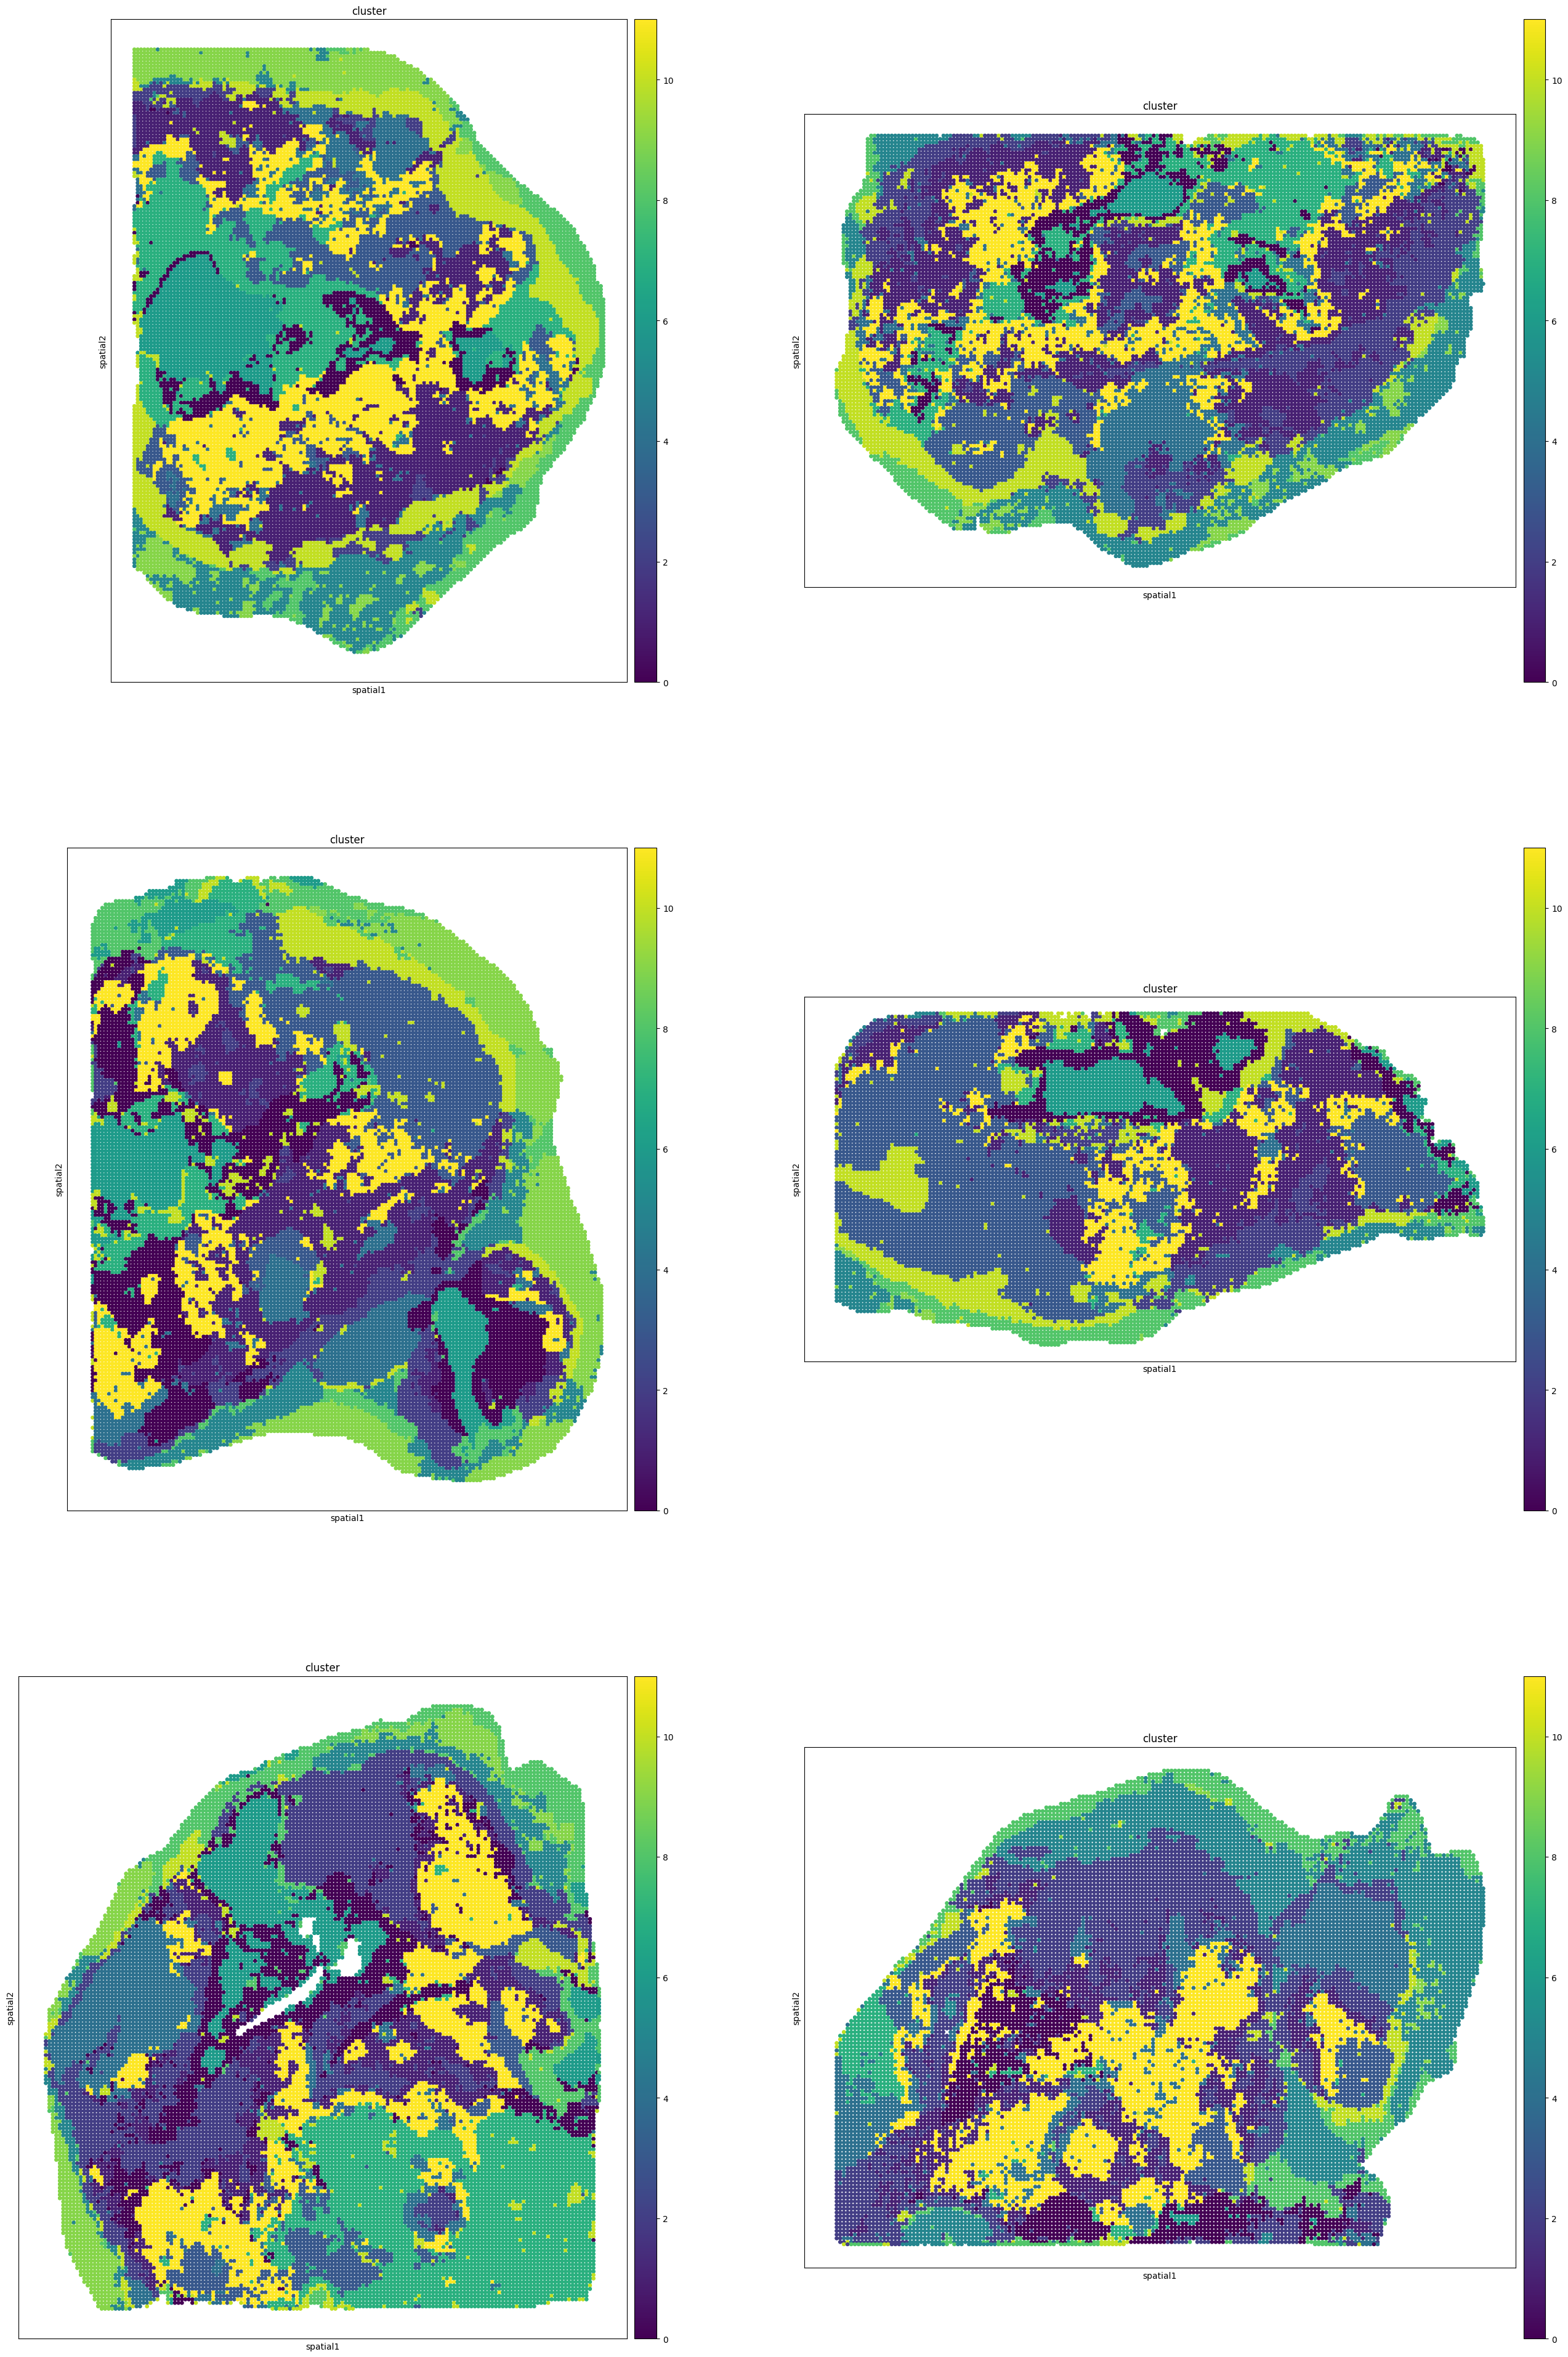

In [13]:
sq.pl.spatial_scatter(
    guide_data, 
    color=['cluster'], 
    library_key='marker',  
    size=50, 
    img=None,
    spatial_key='spatial',
    palette='Set3',
    figsize=(15,15),
    ncols=2,
    shape=None
)

In [14]:
guide_data

AnnData object with n_obs × n_vars = 118279 × 67
    obs: 'marker', 'cov', 'cluster'
    obsm: 'spatial'

In [15]:
c_df = pd.DataFrame(guide_data.X.toarray(), columns=guide_data.var_names)
c_df["marker"] = guide_data.obs["marker"].tolist()
c_df["cluster"] = guide_data.obs["cluster"].tolist()
c_df = c_df.groupby(["marker", "cluster"]).sum().unstack()

In [16]:
c_df

sgAdrb2_1_gene                                             ...  \
cluster             0    1   2    3    4    5    6    7   8    9   ...   
marker                                                             ...   
1-1                117  422  48  450  187  112  151  409  71  152  ...   
1-2                 93  420  89  252  179   51   18  210  24   19  ...   
2-1                281  279  43  922  102   61   72  318  87  173  ...   
2-2                 70   95  11  858    8    7   18   36  34    2  ...   
3-1                  0    0   3    8    1    0    0   11   1    2  ...   
3-2                 14   29  35   38   27   19    0   19  14    0  ...   

        sgZscan12_2_gene                                                 
cluster               2     3    4    5    6    7    8    9    10    11  
marker                                                                   
1-1                   55   449  173  122  162  438  123  147  301  1000  
1-2                  350   771  579  169   76  730   69   66  430  1184  
2-1                   60   978  128   52  114  197  228  204  254   407  
2-2                   31  1340   29   22   27   51   53    8  298   195  
3-1                    8    25    4    1    0   25    1    5    6    12  
3-2                    2     6    3    4    0    1    5    0    3    10  

[6 rows x 804 columns]

In [17]:
p_df = pd.DataFrame()
flag = False
for guide in np.unique(c_df.columns.get_level_values(0)):
    sum_v = c_df[guide].sum(axis=1)
    p_v = (c_df[guide].T / sum_v).T
    if not flag:
        p_df = pd.concat([p_df, p_v.reset_index().melt(id_vars="marker")], axis=1)
        flag = True
    else: p_df = pd.concat([p_df, p_v.reset_index().melt(id_vars="marker").value], axis=1)
pp_df = p_df.iloc[:, 2:]
pp_df.columns = np.unique(c_df.columns.get_level_values(0))
pp_df.index = [str(marker) + "_" + str(cluster) for marker, cluster in zip(p_df["marker"], p_df["cluster"])]

In [18]:
pp_df.fillna(0, inplace=True)

In [19]:
ntc_df = pp_df.T - pp_df.loc[:, "sgNTC"]

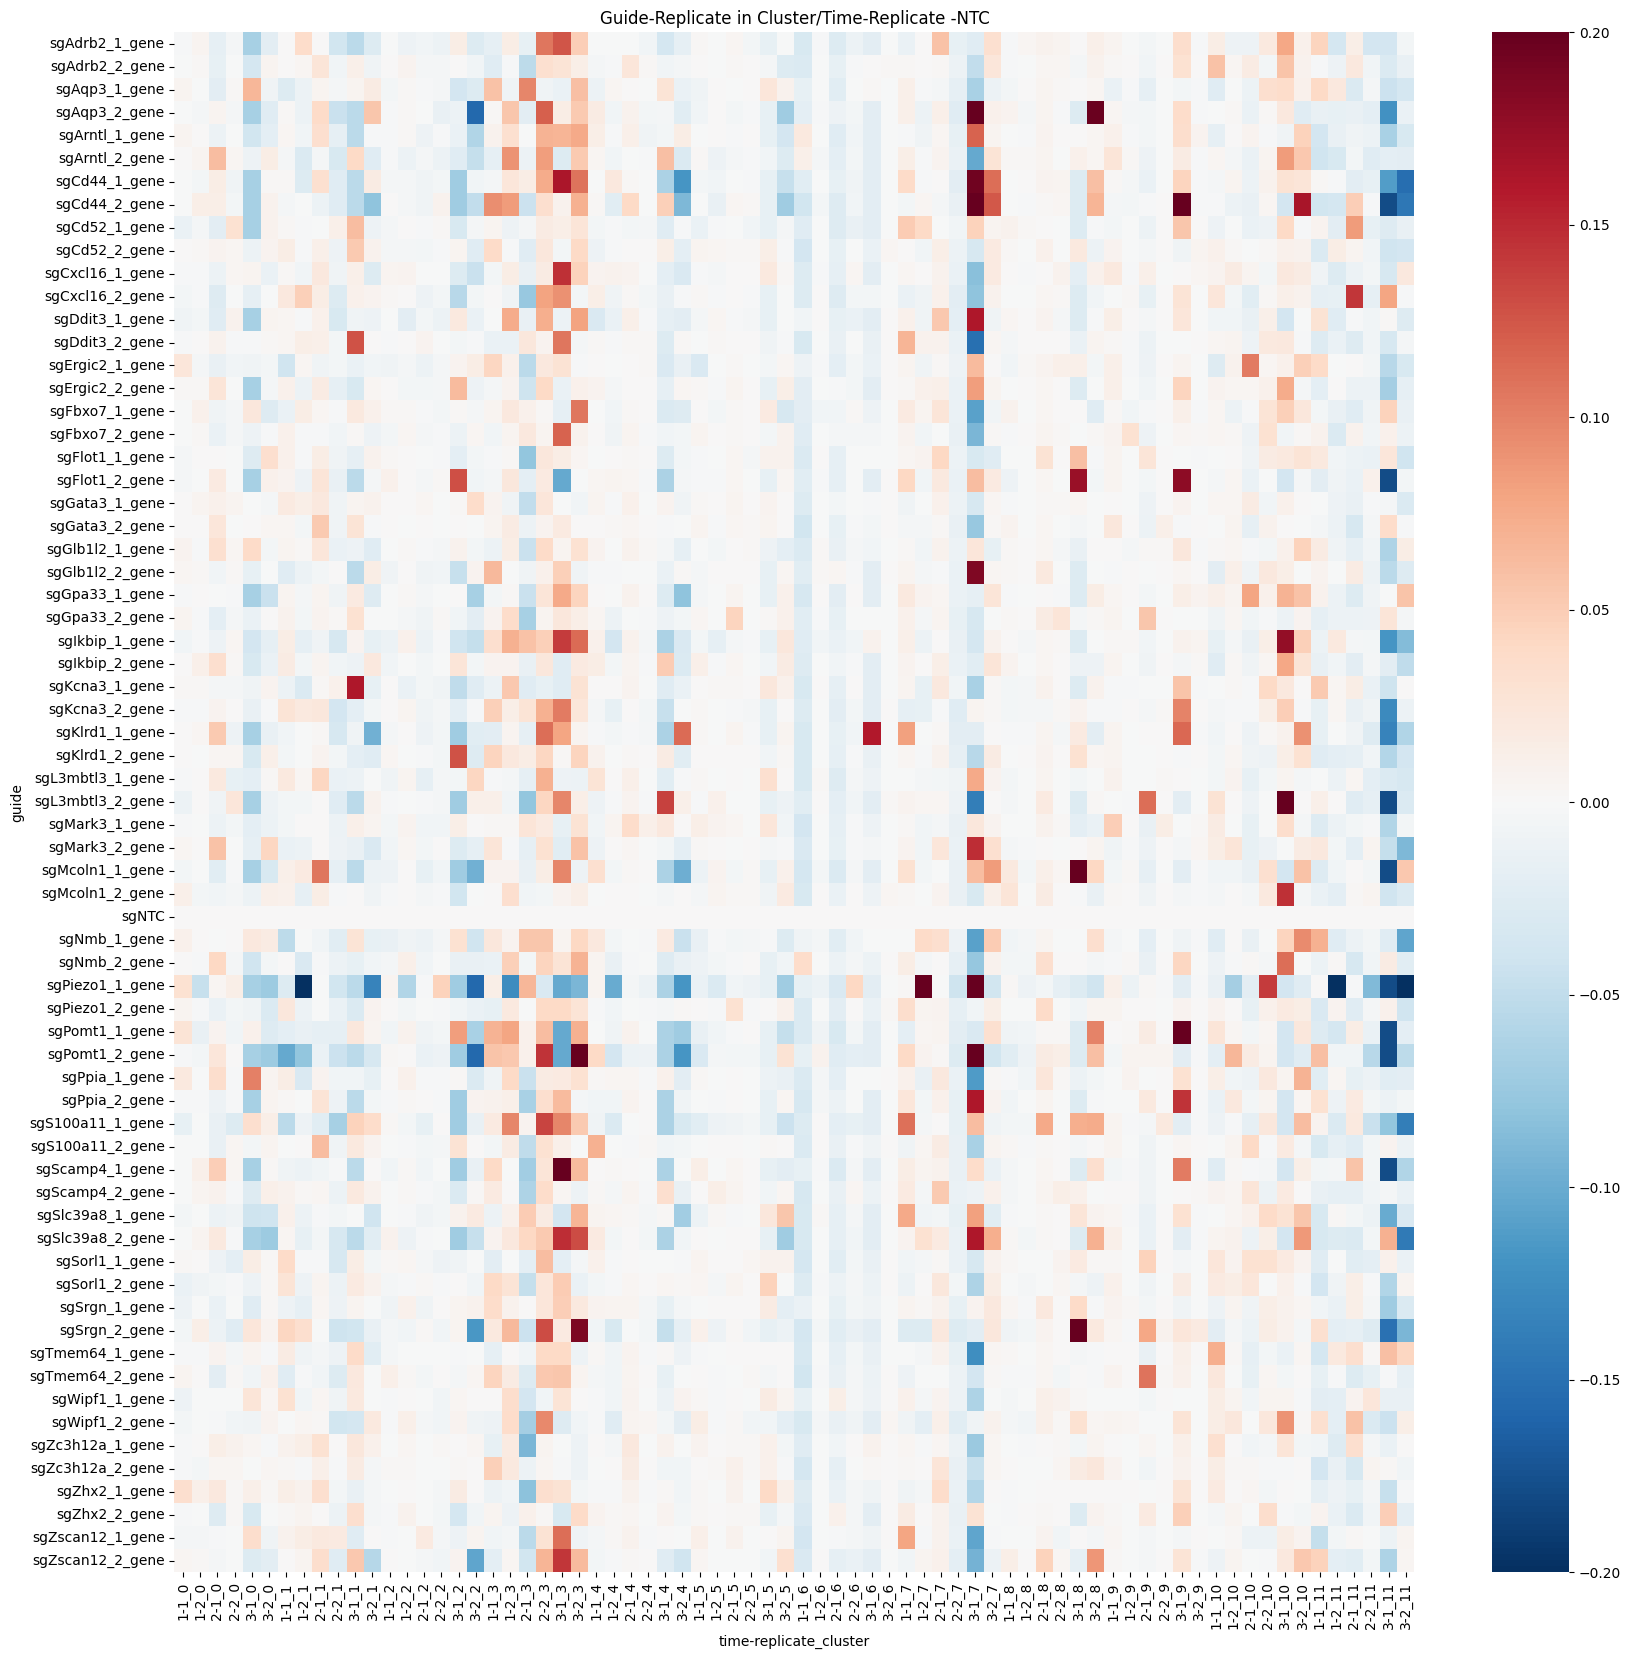

In [20]:
plt.figure(figsize=(20, 20))
sns.heatmap(ntc_df, cmap="RdBu_r", vmax=0.2, vmin=-0.2)

plt.title("Guide-Replicate in Cluster/Time-Replicate -NTC")
plt.ylabel("guide")
plt.xlabel("time-replicate_cluster")
plt.show()

In [23]:
c_df = pd.DataFrame(guide_data.X.toarray(), columns=guide_data.var_names)
c_df["cluster"] = guide_data.obs["cluster"].tolist()
c_df = c_df.groupby(["cluster"]).sum()

p_df = pd.DataFrame()
for guide in np.unique(c_df.columns):
    sum_v = c_df[guide].sum()
    p_v = (c_df[guide].T / sum_v).T
    p_df = pd.concat([p_df, p_v], axis=1)

p_df.columns = np.unique(c_df.columns)

ntc_df = p_df.T - p_df.loc[:, "sgNTC"]

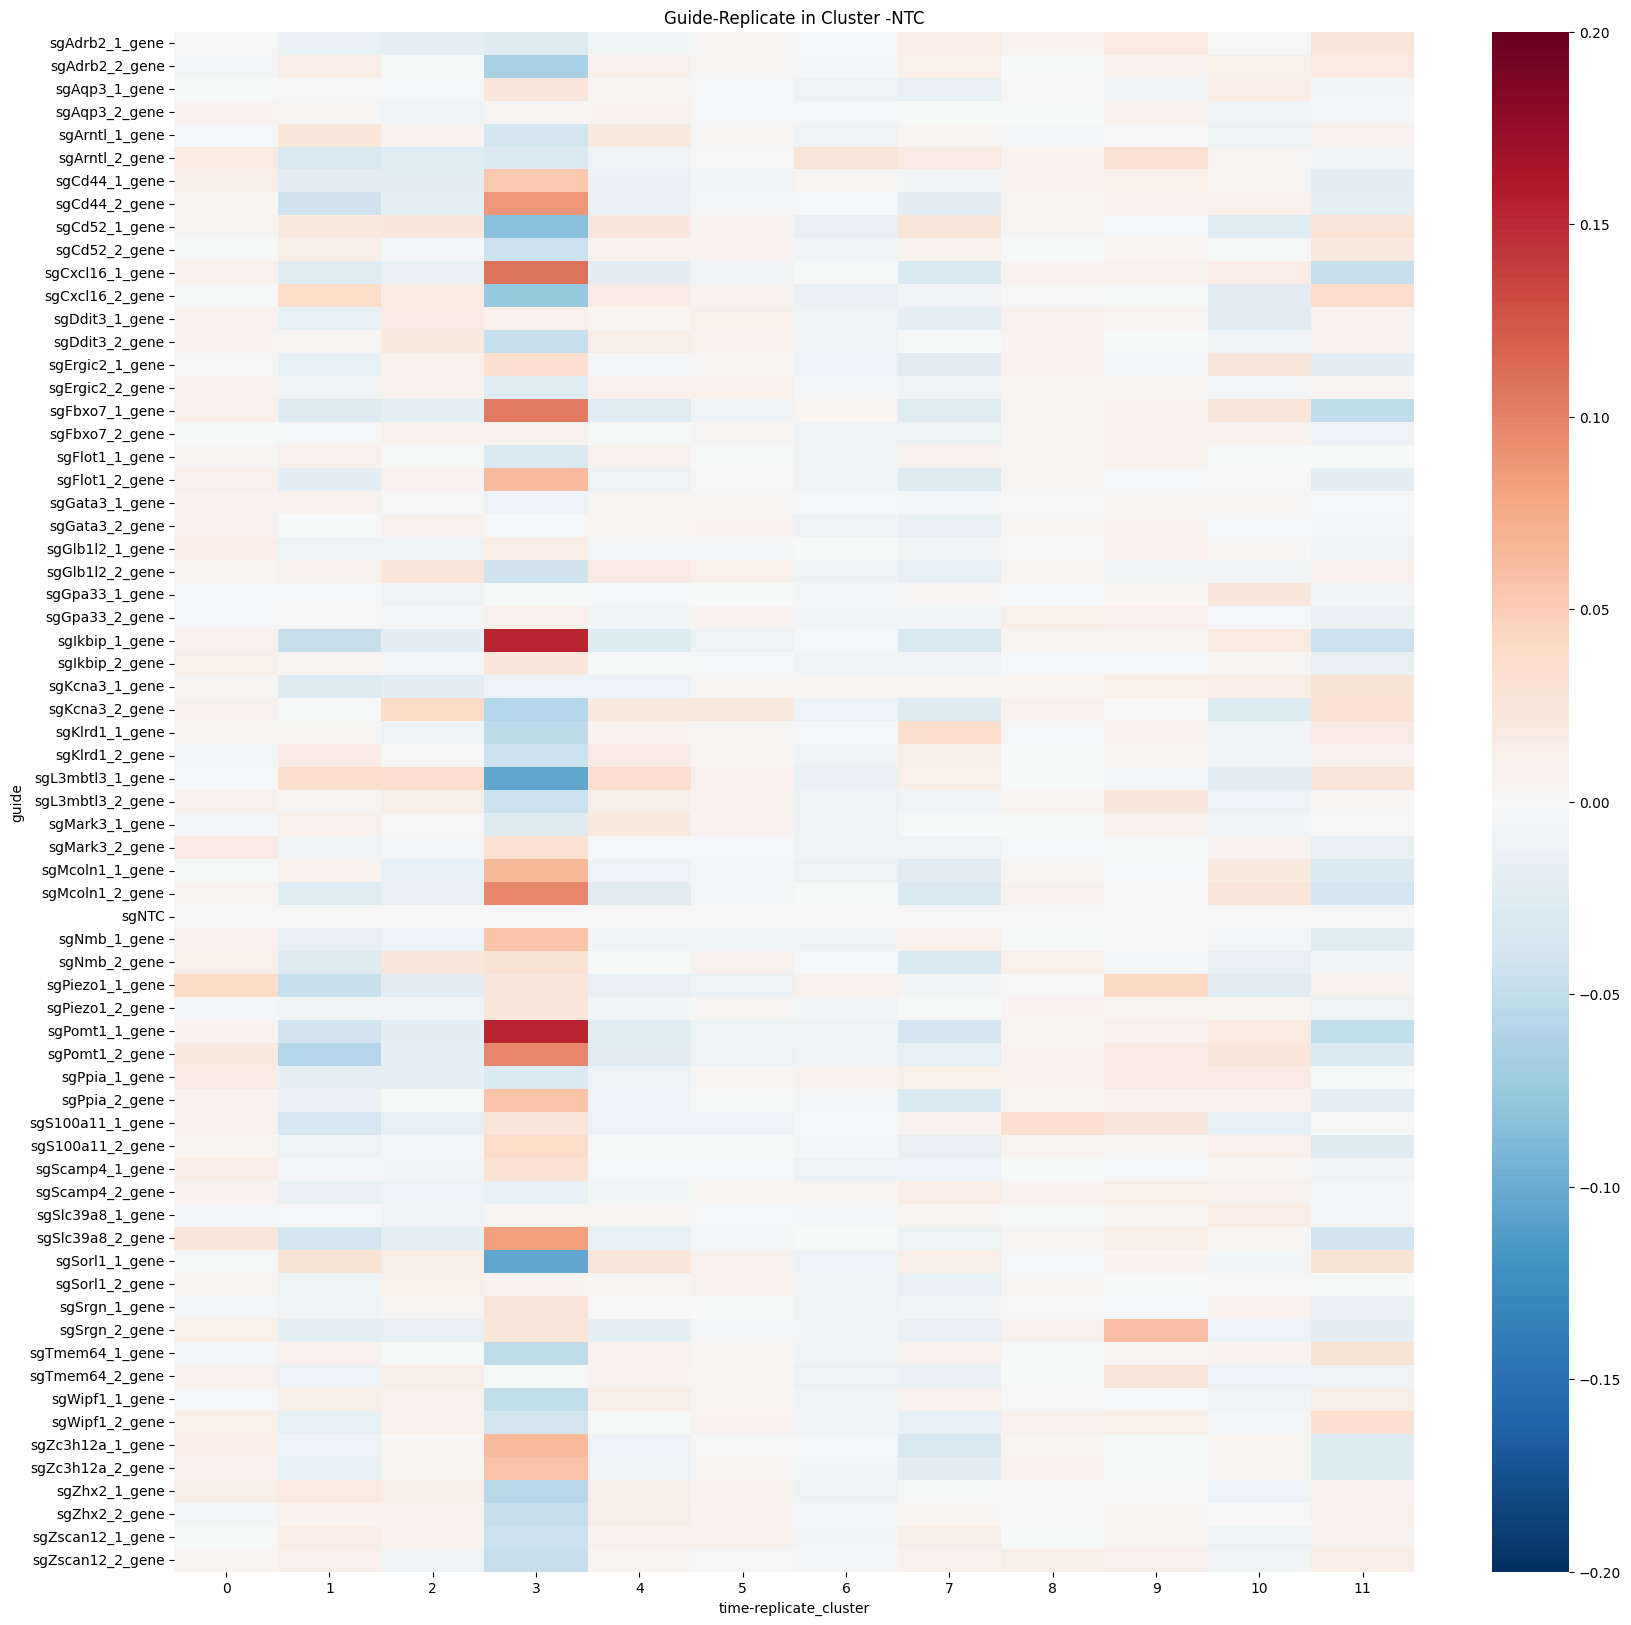

In [25]:
plt.figure(figsize=(20, 20))
sns.heatmap(ntc_df, cmap="RdBu_r", vmax=0.2, vmin=-0.2)

plt.title("Guide-Replicate in Cluster -NTC")
plt.ylabel("guide")
plt.xlabel("time-replicate_cluster")
plt.show()

In [214]:
sgs = guide_data.var_names.str.split('_', n=1).str[0]
sgs_grouped = pd.DataFrame(guide_data.X.toarray(), columns=guide_data.var_names)
sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()
sgdata = ad.AnnData(sgs_grouped, obs=guide_data.obs, var=pd.DataFrame(index=sgs_grouped.columns))
sgdata.obsm['spatial'] = guide_data.obsm['spatial']
gdata = sgdata.copy()

/tmp/ipykernel_36786/3092818934.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [276]:
c_df = pd.DataFrame(gdata.X, columns=gdata.var_names)
c_df["marker"] = gdata.obs["marker"].tolist()
c_df["cluster"] = gdata.obs["cluster"].tolist()
c_df = c_df.groupby(["marker", "cluster"]).sum().unstack()

p_df = pd.DataFrame()
flag = False
for guide in np.unique(c_df.columns.get_level_values(0)):
    sum_v = c_df[guide].sum(axis=1)
    p_v = (c_df[guide].T / sum_v).T
    if not flag:
        p_df = pd.concat([p_df, p_v.reset_index().melt(id_vars="marker")], axis=1)
        flag = True
    else: p_df = pd.concat([p_df, p_v.reset_index().melt(id_vars="marker").value], axis=1)
pp_df = p_df.iloc[:, 2:]
pp_df.columns = np.unique(c_df.columns.get_level_values(0))
pp_df.index = [str(marker) + "_" + str(cluster) for marker, cluster in zip(p_df["marker"], p_df["cluster"])]

ntc_df = pp_df.T - pp_df.loc[:, "sgNTC"]

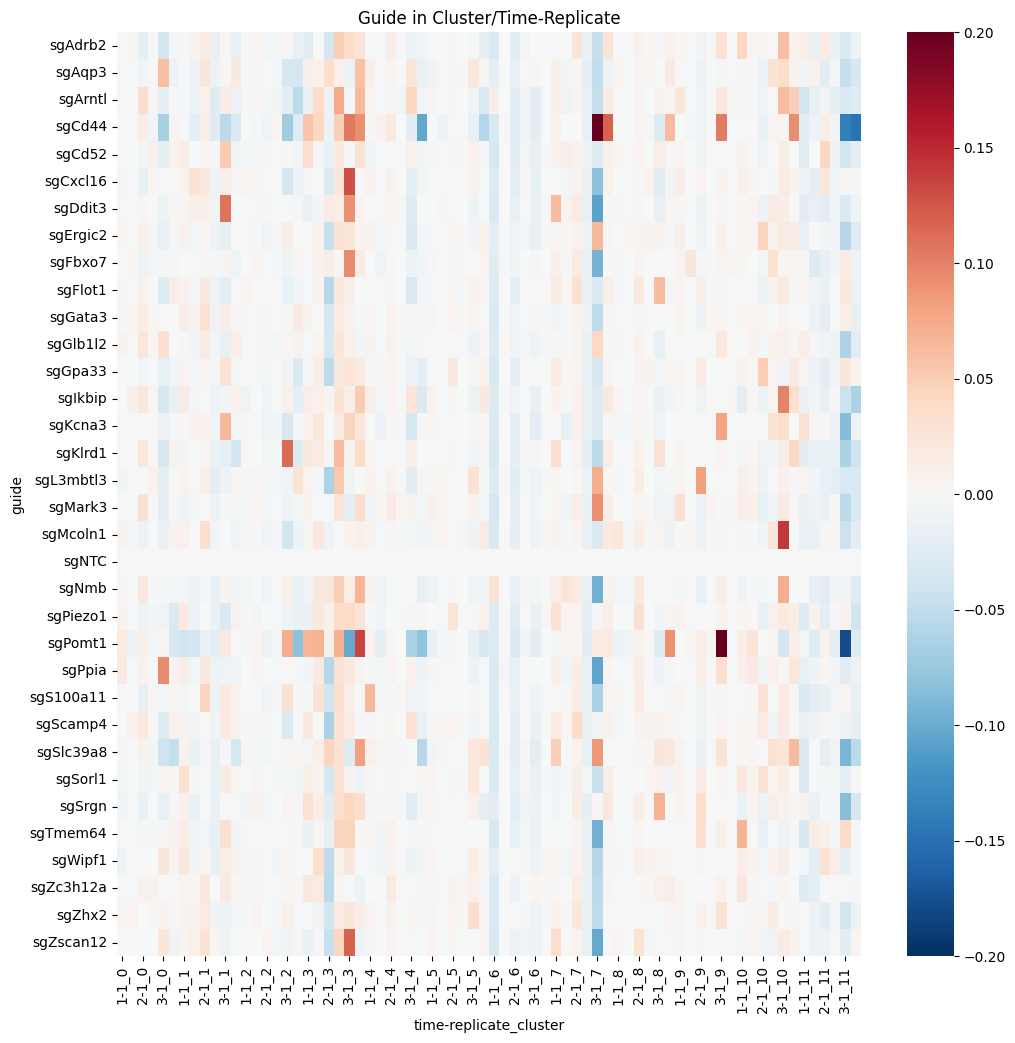

In [277]:
plt.figure(figsize=(12, 12))
sns.heatmap(ntc_df, cmap="RdBu_r", vmax=0.2, vmin=-0.2)

plt.title("Guide in Cluster/Time-Replicate")
plt.ylabel("guide")
plt.xlabel("time-replicate_cluster")
plt.show()

In [333]:
from matplotlib.gridspec import GridSpec

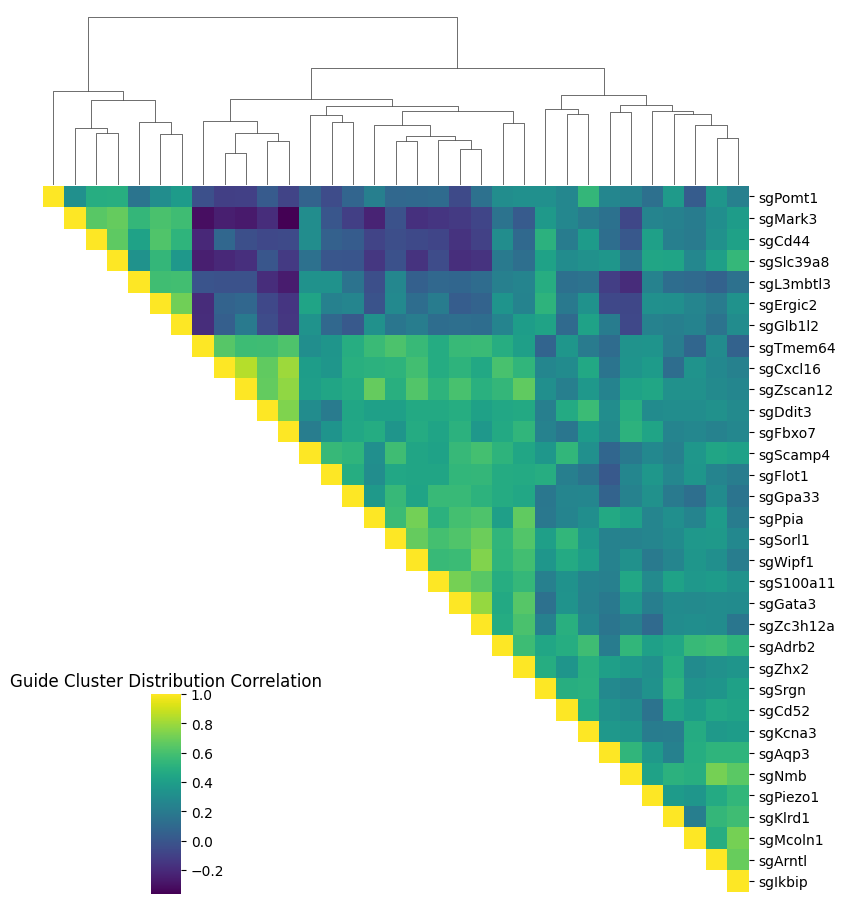

In [355]:
clean_ntc_df = ntc_df[ntc_df.index != "sgNTC"]
correlation_matrix = clean_ntc_df.T.corr()

# 使用 seaborn 的 clustermap 绘制热图，并只对 x 轴进行聚类
g = sns.clustermap(correlation_matrix, cmap='viridis', figsize=(10, 10), col_cluster=True, row_cluster=True)

# 只显示右上角部分的矩阵，并保留颜色条
g.ax_row_dendrogram.set_visible(False)

# 获取聚类后的索引顺序
clustered_index = g.dendrogram_row.reordered_ind
clustered_columns = g.dendrogram_col.reordered_ind

# 创建一个新的掩码，只显示右上角部分
mask = np.zeros_like(correlation_matrix, dtype=bool)
mask[np.tril_indices_from(mask, -1)] = True

for i in range(len(mask)):
    for j in range(len(mask)):
        if mask[clustered_index[i], clustered_columns[j]]:
            g.ax_heatmap.add_patch(plt.Rectangle((clustered_columns[j], clustered_index[i]), 1, 1, fill=True, color='white', lw=0))

g.ax_heatmap.xaxis.tick_top()
g.ax_heatmap.xaxis.set_label_position('top')

g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks(np.arange(len(correlation_matrix.index)) + 0.5)
g.ax_heatmap.set_yticklabels(correlation_matrix.index[clustered_index])

cbar = g.ax_heatmap.collections[0].colorbar
cbar.ax.set_position([0.3, 0.1, 0.03, 0.2])  # [left, bottom, width, height]

plt.title('Guide Cluster Distribution Correlation')

plt.show()

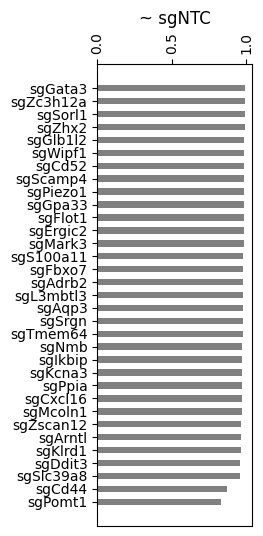

In [387]:
# calculate ntc correlation with guide
guide_corr = {}
for guide in gdata.var_names[gdata.var_names != "sgNTC"]:
    p = pearsonr(pp_df[guide], pp_df["sgNTC"])[0]
    guide_corr[guide] = p
r_df = pd.DataFrame(guide_corr, index=['Pearsonr'])
r_df = r_df.T.sort_values(by="Pearsonr").T
plt.figure(figsize=(2, 6))
plt.barh(r_df.columns, r_df.iloc[0], height=0.5, color="Grey")
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.xticks(rotation=90)
plt.title("~ sgNTC")
plt.show()

In [219]:
c_df = pd.DataFrame(gdata.X, columns=gdata.var_names)
c_df["marker"] = gdata.obs["marker"].str.split("-").str.get(0).tolist()
c_df["cluster"] = gdata.obs["cluster"].tolist()
c_df = c_df.groupby(["marker", "cluster"]).sum().unstack()

p_df = pd.DataFrame()
flag = False
for guide in np.unique(c_df.columns.get_level_values(0)):
    sum_v = c_df[guide].sum(axis=1)
    p_v = (c_df[guide].T / sum_v).T
    if not flag:
        p_df = pd.concat([p_df, p_v.reset_index().melt(id_vars="marker")], axis=1)
        flag = True
    else: p_df = pd.concat([p_df, p_v.reset_index().melt(id_vars="marker").value], axis=1)
pp_df = p_df.iloc[:, 2:]
pp_df.columns = np.unique(c_df.columns.get_level_values(0))
pp_df.index = [str(marker) + "_" + str(cluster) for marker, cluster in zip(p_df["marker"], p_df["cluster"])]

ntc_df = pp_df.T - pp_df.loc[:, "sgNTC"]

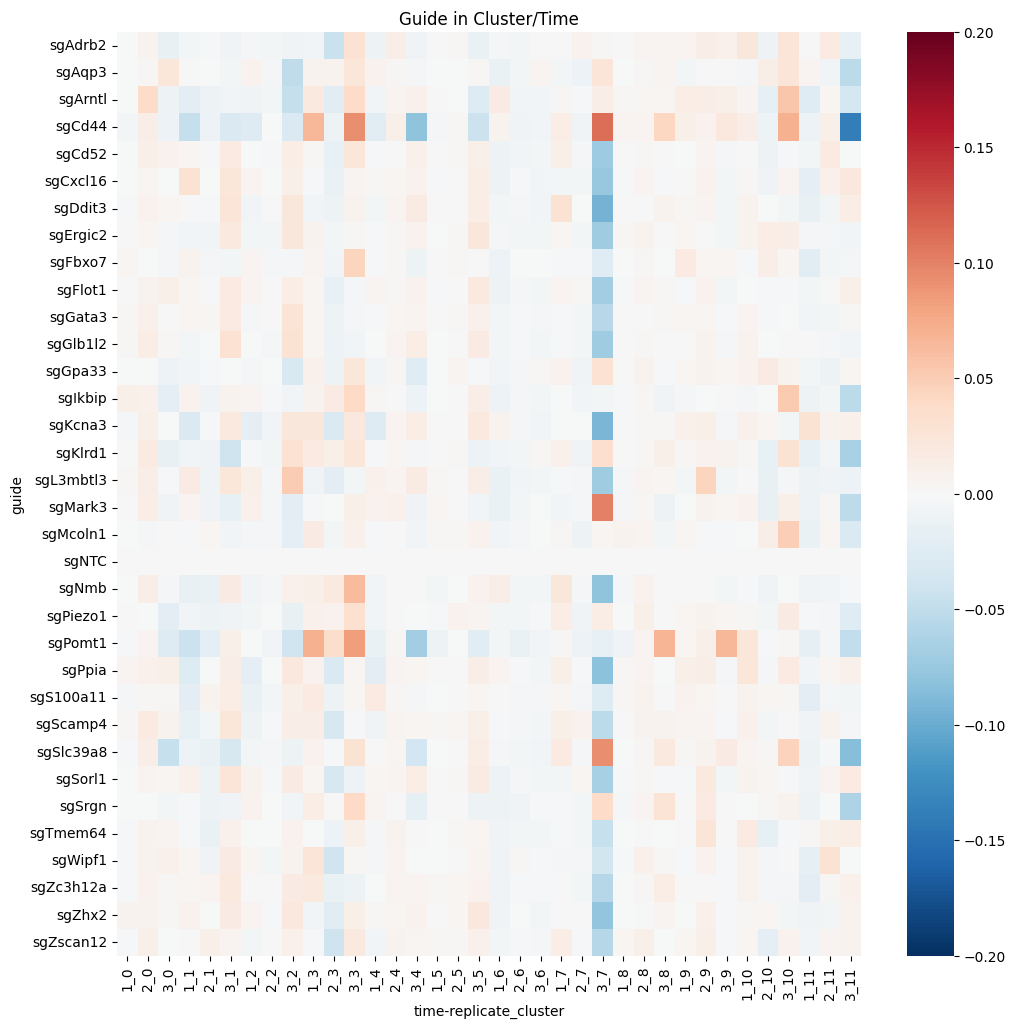

In [220]:
plt.figure(figsize=(12, 12))
sns.heatmap(ntc_df, cmap="RdBu_r", vmax=0.2, vmin=-0.2)

plt.title("Guide in Cluster/Time")
plt.ylabel("guide")
plt.xlabel("time-replicate_cluster")
plt.show()

In [118]:
p_v

cluster
0     0.102009
1     0.147638
2     0.074248
3     0.098148
4     0.065768
5     0.050803
6     0.048380
7     0.095119
8     0.048632
9     0.065970
10    0.061882
11    0.141404
Name: sgAdrb2, dtype: float64

In [260]:
c_df = pd.DataFrame(gdata.X, columns=gdata.var_names)
c_df["cluster"] = gdata.obs["cluster"].tolist()
c_df = c_df.groupby(["cluster"]).sum()

p_df = pd.DataFrame()
for guide in np.unique(c_df.columns):
    sum_v = c_df[guide].sum()
    p_v = (c_df[guide].T / sum_v).T
    p_df = pd.concat([p_df, p_v], axis=1)

p_df.columns = np.unique(c_df.columns)

ntc_df = p_df.T - p_df.loc[:, "sgNTC"]

<Figure size 1200x1200 with 0 Axes>

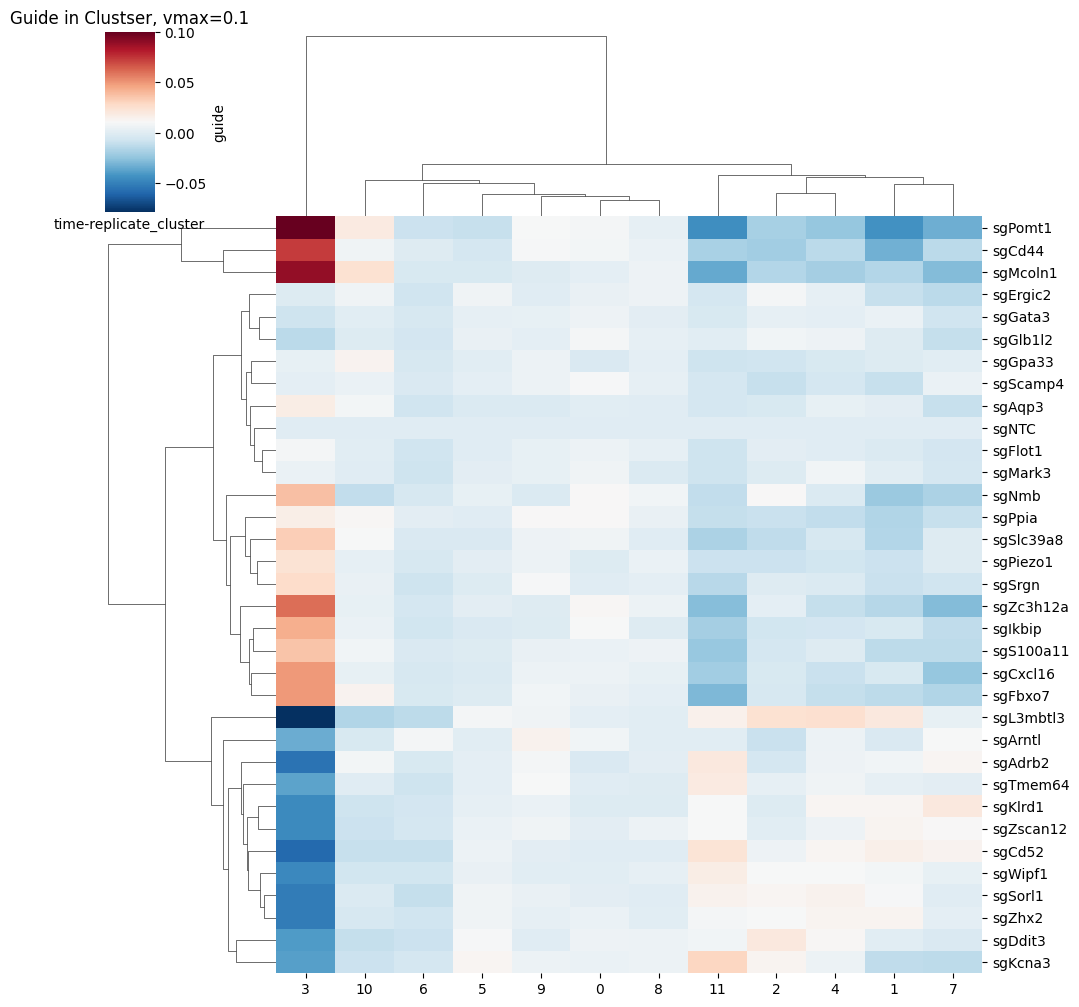

In [261]:
plt.figure(figsize=(12, 12))
sns.clustermap(ntc_df, cmap="RdBu_r", vmax=0.1)

plt.title("Guide in Clustser, vmax=0.1")
plt.ylabel("guide")
plt.xlabel("time-replicate_cluster")
plt.show()

# Guide Correlation

In [270]:
sgs = guide_data.var_names.str.split('_', n=1).str[0]
sgs_grouped = pd.DataFrame(guide_data.X.toarray(), columns=guide_data.var_names)
sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()
sgdata = ad.AnnData(sgs_grouped, obs=guide_data.obs, var=pd.DataFrame(index=sgs_grouped.columns))
sgdata.obsm['spatial'] = guide_data.obsm['spatial']
gdata = sgdata.copy()

/tmp/ipykernel_36786/3092818934.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [228]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

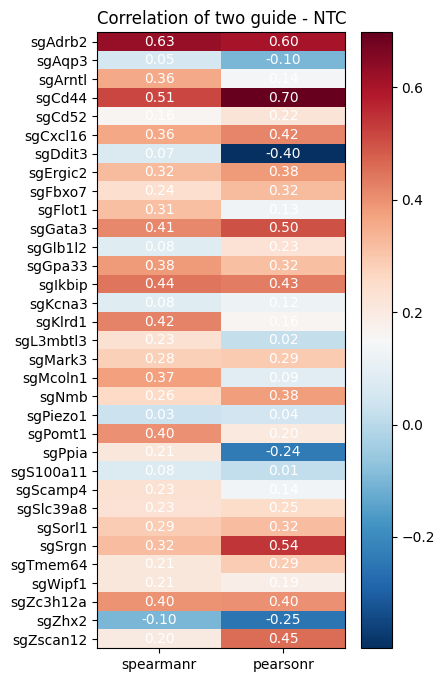

In [275]:
p_df = {}
ntc_df = ntc_df.T
for guide in gdata.var_names:
    if guide != "sgNTC":
        p = spearmanr(ntc_df.loc[:, guide + "_1_gene"], ntc_df.loc[:, guide + "_2_gene"])[0]
        p_ = pearsonr(ntc_df.loc[:, guide + "_1_gene"], ntc_df.loc[:, guide + "_2_gene"])[0]
        p_df[guide] = {
            "spearmanr": p,
            "pearsonr": p_
        }
p_df = pd.DataFrame(p_df).T
plt.figure(figsize=(4, 8))
plt.imshow(p_df, cmap='RdBu_r', aspect='auto')

plt.colorbar()
plt.xticks(np.arange(p_df.shape[1]), p_df.columns)
plt.yticks(np.arange(p_df.shape[0]), p_df.index)

# 在每个单元格中标注数据
for i in range(p_df.shape[0]):
    for j in range(p_df.shape[1]):
        plt.text(j, i, f'{p_df.iloc[i, j]:.2f}', ha='center', va='center', color='white')

plt.title('Correlation of two guide - NTC')
plt.show()